In [13]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVDpp, SVD
from surprise.prediction_algorithms.knns import KNNBaseline
from lenskit import crossfold as xf
import implicit
from scipy.sparse import coo_matrix
import datadotworld as dw
import random
random.seed(7)

## Project 4 Recommender System Evaluations

### Load Data

For this project, we'll use the famous movieLens dataset.  Out of the 5 tables in the dataset, we'll use 2.  The first table contains about 100,000 movie ratings sampled from 610 users.  The second relvent table contains a score vector related to the content of each movie.  This score vector was created using a combination of user-defined tags and text data.  Each dimension in the vector represents one of over 1128 latent features. 

In [14]:
lds =dw.load_dataset('https://data.world/pgoodridge2007/genome-movies')
scores = lds.dataframes['genome_scores']
scores.columns = ['item', 'tagId', 'relevance']
ratings = pd.read_csv('https://raw.githubusercontent.com/TheFedExpress/DATA612/master/Project%204/ratings.csv', skiprows = 1, 
                      names = ['user', 'item', 'rating', 'timestamp'])
movies = pd.read_csv('https://raw.githubusercontent.com/TheFedExpress/DATA612/master/Project%204/movies.csv', 
                     skiprows = 1, names = ['item', 'title', 'tags'])

movies_score = movies.merge(scores, on = 'item',  how = 'inner')
all_movies = set(movies_score.item.values)
ratings_sub = ratings.loc[ratings.item.isin(all_movies)]

## Helper Functions for Evaluation

We'll want to define custom functions for two reasons.  First, we'll be using the lensKit library to perform crossvalidation split by user.  Additionally, some of our measures won't match the standard confusion matrix based measures defined in sklearn.  

### Confusion Matrix

We define two functions to prepare predicted and actual values for a confusion matrix.  One is for ordinal feedback and the other is for binary feedback.

In the context of recommender systems the following defintions are used:

- True positives: Recommended items that were consumed by the user (at least 3.5 stars)
- False positives: Recommended items that were not consumed by the user
- False negatives: Items consumed by the user (at least 3.5 stars) that were not recommended
- True negatives: Items not consumed by the user that were not recommended

For non-binary predictions of rating, the requirement in parenthesis must be fulfilled to count as relevent.

In [15]:
def decision(df):
    if df['rating'] < 3.5 and np.isnan(df['Predicted Rating']) == 1:
        return 'tn'
    elif df['rating'] >= 3.5 and np.isnan(df['Predicted Rating']) == 1:
        return 'fn'
    elif df['rating'] < 3.5 and np.isnan(df['Predicted Rating']) == 0:
        return 'fp'
    elif np.isnan(df['rating']) == 1 and np.isnan(df['Predicted Rating']) == 0:
        return 'fp'
    elif df['rating'] >= 3.5 and np.isnan(df['Predicted Rating']) == 0:
        return 'tp'
    
def decision_binary(df):
    if np.isnan(df['rating']) == 1 and np.isnan(df['Predicted Rating']) == 1:
        return 'tn'
    elif np.isnan(df['rating']) == 0 and np.isnan(df['Predicted Rating']) == 1:
        return 'fn'
    elif np.isnan(df['rating']) == 1 and np.isnan(df['Predicted Rating']) == 0:
        return 'fp'
    elif np.isnan(df['rating']) == 0 and np.isnan(df['Predicted Rating']) == 0:
        return 'tp'


### Calclulations

In [16]:
def sq_error(df):
    return (df['rating'] - df['Predicted Rating']) **2

def rmse(df):
    return (df.error.mean()) **.5
    
    
def metrics(df):
    confusion = df.groupby('truth').size()
    precision = confusion.tp/(confusion.tp + confusion.fp)
    recall = confusion.tp/(confusion.tp + confusion.fn)
    return confusion, precision, recall

### Peformance Measures

These functions are the core of our custom package.

**Metrics at K**: Calculates 3 metrics assuming the recommender returns K recommendations.

- Precision: True positives divided by (True positives + False positives)
- Recall: True positives divided by (True positives + False Negatives)
- Coverage: Count of distinct items recommended to all users divided by total distinct items.  This is the simplest KPI for diversity

These 3 metrics are shown at different levels of K using the "precision_recall" function.  In the plot of precision vs recall, we'd like to see a concave up pattern.  Precision deteriorates at a slower rate than recall increases.

In [17]:
def get_svd_recs(predictions, k):
    
    return predictions.groupby('user').apply(lambda x: x.nlargest(k, columns = 'Predicted Rating'))

def metrics_at_k(predictions, train_sets, test_sets, k, cv_splits, is_binary = False):
    precs, recs, covs = [], [], []
    for i in range(cv_splits):
        all_recs = get_svd_recs(predictions[i], k)
        test_set = test_sets[i].copy()
        test_set.set_index(['item', 'user'], inplace = True)
        recs_eval = (all_recs.set_index(['item', 'user'])
            .join(test_set, how = 'outer')        
        )
        if is_binary == False:
            recs_eval['truth'] = recs_eval.apply(decision, axis = 1)
        else:
            recs_eval['truth'] = recs_eval.apply(decision_binary, axis = 1)
        _ , precision, recall = metrics(recs_eval)
        recs.append(recall)
        precs.append(precision)
        
        train_set = train_sets[i]
        coverage = len(set(all_recs.item))/len(set(train_set.item))
        covs.append(coverage)
        
    precicsion_mean = sum(precs)/cv_splits
    recall_mean = sum(recs)/cv_splits
    coverage_mean = sum(covs)/cv_splits
    summary_df = pd.DataFrame({'K': [k], 'Precision': ['{:.3f}'.format(precicsion_mean)],
                               'Recall': ['{:.3f}'.format(recall_mean)],
                               'Item Coverage': ['{:.3f}'.format(coverage_mean)]
    })
    return summary_df

def precision_recall(predictions, train_sets, test_sets, cv_splits, is_binary = False):
    dfs = []
    for i in range(10,90, 10):
        dfs.append(metrics_at_k(predictions, train_sets, test_sets, i, cv_splits, is_binary))
    df = pd.concat(dfs)
    df = df.astype({'Precision': 'float64', 'Recall': 'float64', 'Item Coverage': 'float64'})

    df.plot(kind = 'line', x = 'Recall', y = 'Precision',
        title = 'Precision vs Recall')
    return df
    
def standard_rmse(predictions, cv_splits, test_sets):
    rmses = []
    for i in range(cv_splits):
        all_recs = predictions[i].copy()
        test = test_sets[i].copy()
        test.set_index(['item', 'user'], inplace = True)
        recs_eval = (all_recs.set_index(['item', 'user'])
            .join(test, how = 'inner')        
        )
        recs_eval['error'] = recs_eval.apply(sq_error, axis = 1)
        rmse_split = rmse(recs_eval)
        rmses.append(rmse_split)
    rmse_mean = sum(rmses)/cv_splits
    summary_df = pd.DataFrame({'RMSE': ['{:.3f}'.format(rmse_mean)]})
    return summary_df

## Model Evaluations

### Nearest Neighbor Model

In [32]:
pred_splits_nn = []
test_sets_nn = []
train_sets_nn = []
for train, test in xf.partition_users(ratings_sub[['user', 'item', 'rating']], 2, xf.SampleFrac(0.2)):
    reader = Reader(rating_scale=(.5, 5))
    movies_data = Dataset.load_from_df(train.iloc[:, :3], reader)
    trainset = movies_data.build_full_trainset()
    testset = trainset.build_anti_testset()
    best_knn = KNNBaseline(k = 30, sim_options = {'name': 'pearson_baseline', 'user_based': False})
    best_knn.fit(trainset)
    predictions = (pd.DataFrame(best_knn.test(testset), columns = ['user', 'item', 'act_rating', 'Predicted Rating', 'details'])
        .drop(columns = ['act_rating', 'details'])
    )    
    pred_splits_nn.append(predictions)
    test_sets_nn.append(test)
    train_sets_nn.append(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [20]:
standard_rmse(pred_splits_nn, 2, test_sets_nn)

,RMSE
0,0.843


,K,Precision,Recall,Item Coverage
0,10,0.016,0.016,0.194
0,20,0.017,0.034,0.271
0,30,0.016,0.049,0.326
0,40,0.016,0.064,0.364
0,50,0.015,0.076,0.398
0,60,0.014,0.089,0.425
0,70,0.014,0.101,0.450
0,80,0.014,0.112,0.470


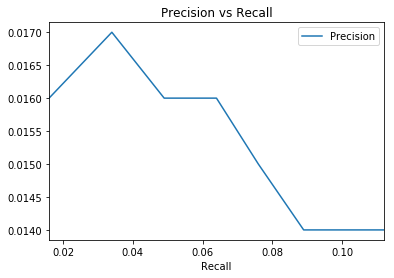

In [33]:
precision_recall(pred_splits_nn, train_sets_nn, test_sets_nn, 2)

### SVD Model

In [22]:
pred_splits = []
test_sets = []
train_sets = []
for train, test in xf.partition_users(ratings_sub[['user', 'item', 'rating']], 2, xf.SampleFrac(0.2)):
    reader = Reader(rating_scale=(.5, 5))
    movies_data = Dataset.load_from_df(train.iloc[:, :3], reader)
    trainset = movies_data.build_full_trainset()
    testset = trainset.build_anti_testset()
    best_svd = SVD(n_factors = 30, reg_all = .1, n_epochs = 50, lr_all = .001)
    best_svd.fit(trainset)
    predictions = (pd.DataFrame(best_svd.test(testset), columns = ['user', 'item', 'act_rating', 'Predicted Rating', 'details'])
        .drop(columns = ['act_rating', 'details'])
    )    
    pred_splits.append(predictions)
    test_sets.append(test)
    train_sets.append(train)

In [23]:
standard_rmse(pred_splits, 2, test_sets)

,RMSE
0,0.871


,K,Precision,Recall,Item Coverage
0,10,0.038,0.040,0.009
0,20,0.034,0.071,0.014
0,30,0.031,0.096,0.018
0,40,0.028,0.115,0.022
0,50,0.025,0.132,0.026
0,60,0.024,0.147,0.030
0,70,0.022,0.163,0.034
0,80,0.021,0.175,0.038


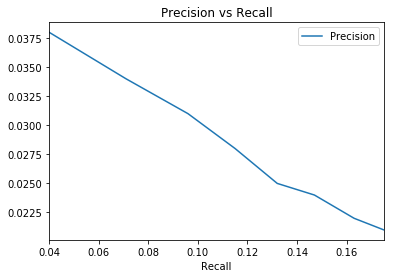

In [24]:
precision_recall(pred_splits, train_sets, test_sets, 2)

Because a binary prediction is easier to include in an ensemble, we'll check out the performance when an actual rating of 3.5 or better is not required for a true positive.  This is used as a comparison point for future models.

This isn't actually that much of a concession, as an argument could be made that the goal of most recommenders is to predict whether a user will consume the item, regardless of rating.  The user was engaged regardless of whether they gave the content a high rating.

,K,Precision,Recall,Item Coverage
0,10,0.044,0.028,0.009
0,20,0.039,0.050,0.014
0,30,0.036,0.068,0.018
0,40,0.032,0.082,0.022
0,50,0.030,0.094,0.026
0,60,0.028,0.105,0.030
0,70,0.026,0.117,0.034
0,80,0.025,0.127,0.038


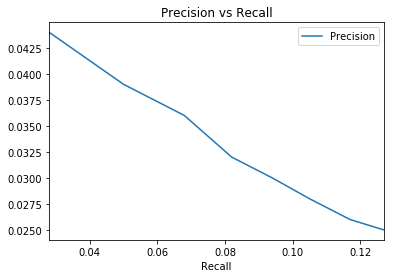

In [25]:
precision_recall(pred_splits, train_sets, test_sets, 2, is_binary = True)

### Evaluation

While the RMSEs are similar, the SVD model far outperforms KNN in precision and recall.  This adds credence to the contention that RMSE should not be the target in recommender evaluation.  SVD is also more scalable, as even with this small user-item matrix, the KNN algorithm took around five minutes to run.  KNN has much better coverage, but it's accuracy is too low to consider it.

Though precision and recall are not as high as we'd like, the most striking feature of SVD is the coverage.  Less than 2% of all movies are included in recommendations at a K of 30.  

### ALS Model

For the ALS model, we'll use a binary user-item matrix.  This is a precursor to our mixture model.

In [26]:
binary_ratings = ratings_sub.copy()
binary_ratings.rating = 1

pred_splits_als, test_sets_als, train_sets_als = [], [], []
k = 100
for train, test in xf.partition_users(binary_ratings[['user', 'item', 'rating']], 2, xf.SampleFrac(0.2)):
    item_user = coo_matrix((train['rating'].astype(float), 
                   (train['item'].values, 
                    train['user'].values)))
    user_items = item_user.T.tocsr()
    best_als = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
    
    best_als.fit(item_user)
    all_preds = []
    for user in set(train['user'].values):
        all_preds += zip([user for i in range(k)], best_als.recommend(user, user_items, k))
    temp = pd.DataFrame(all_preds, columns = ['user', 'preds'])
    temp1 = pd.DataFrame(temp['preds'].to_list())
    predictions = pd.concat([temp['user'], temp1], axis = 1)
    predictions.columns = ['user', 'item', 'Predicted Rating']   
    pred_splits_als.append(predictions)
    test_sets_als.append(test)
    train_sets_als.append(train)

100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:01<00:00, 16.31it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:01<00:00, 16.62it/s]


,K,Precision,Recall,Item Coverage
0,10,0.138,0.087,0.067
0,20,0.112,0.141,0.100
0,30,0.097,0.184,0.124
0,40,0.086,0.218,0.144
0,50,0.078,0.247,0.163
0,60,0.072,0.271,0.181
0,70,0.067,0.295,0.196
0,80,0.062,0.315,0.209


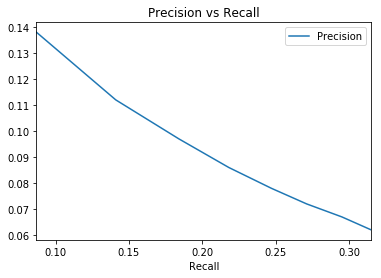

In [27]:
precision_recall(pred_splits_als, train_sets_als, test_sets_als, 2, is_binary = True)

Performance increases considerably over the previous two collaborative filtering algorithms.  This could be because this binary classification was actually train on binary data.  However, the contrast is so stark that I'd want to look at the source code to see if there are problems with the Surprise Library if I were to consider using Surprise in a business setting.

## Business Objective

For this section, we'll assume the following: The business is a movie streaming service.  We have a wide variety of movies in our inventory that are not being presented to users.  We are concerned that our users will grow bored of our platform after being presented with the low variety over and over.

Up to this point, the recommenders are only returning a small portion of our movie list.  Even the most accurate recommender, ALS is only showing users about 10% of our total movie inventory at a K of 20.

### Hybrid Model

In [28]:
def mixture(df, mixing = (.6, .4)):
    df['Predicted Rating'] = df['pred_1'] * mixing[0] + df['pred_2'] * mixing[1]
    return df


def get_similarity_rating(sim_df, movie1):
        
    return sim_df.loc[movie1, sim_df.columns != movie1]
        
def calc_user(user_id, ratings_df, sim_df):
    
    dfs = []
    temp1 = ratings_df.loc[ratings_df.user == user_id, ['item', 'rating']]
    if len(temp1 > 100):
        temp1 = ratings_df.loc[ratings_sub.user == user_id, ['item', 'rating']][:100]
    for _, movie, _ in temp1.itertuples():
        dfs.append(pd.DataFrame(get_similarity_rating(sim_df, movie)))
    avg_temp = pd.DataFrame(pd.concat(dfs, axis = 1, join = 'inner').mean(axis = 1))
    avg_temp['user'] = user_id
    return avg_temp

In [29]:
pred_splits_h = []
test_sets_h = []
train_sets_h = []
k = len(all_movies)
for train, test in xf.partition_users(binary_ratings[['user', 'item', 'rating']], 2, xf.SampleFrac(0.2)):
    item_user = coo_matrix((train['rating'].astype(float), 
                   (train['item'].values, 
                    train['user'].values)))
    user_items = item_user.T.tocsr()
    best_als = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
    
    best_als.fit(item_user)
    all_preds = []
    train_users = set(train['user'].values)
    for user in train_users:
        all_preds += zip([user for i in range(k)], best_als.recommend(user, user_items, k))
    temp = pd.DataFrame(all_preds, columns = ['user', 'preds'])
    temp1 = pd.DataFrame(temp['preds'].to_list())
    predictions = pd.concat([temp['user'], temp1], axis = 1)
    predictions.columns = ['user', 'item', 'pred_1']
    predictions.set_index(['item', 'user'], inplace = True)
    
    movies_sub = movies_score[movies_score.item.isin(set(train['item'].values))]
    movies_pivot = (movies_sub.pivot(index = 'item', 
        columns = 'tagId', values = 'relevance')
    )
        
    content_sim = (pd.DataFrame(cosine_similarity(movies_pivot), 
        columns = movies_pivot.index, index = movies_pivot.index)
    )
    
    all_ratings = [calc_user(user, train, content_sim) for user in train_users]
    final_preds = pd.concat(all_ratings)
    final_preds.columns = ['pred_2', 'user']
    final_preds.reset_index(inplace = True)
    final_preds.set_index(['item', 'user'], inplace = True)
    
    predictions_mix = (pd.concat([predictions, final_preds], axis = 1, join = 'inner')
        .pipe(mixture)
        .drop(columns = ['pred_1', 'pred_2'])
        .reset_index()
    )
    
    pred_splits_h.append(predictions_mix)
    test_sets_h.append(test)
    train_sets_h.append(train)


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:01<00:00, 17.59it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:01<00:00, 16.23it/s]


,K,Precision,Recall,Item Coverage
0,10,0.141,0.089,0.075
0,20,0.114,0.144,0.115
0,30,0.098,0.184,0.149
0,40,0.087,0.219,0.179
0,50,0.078,0.247,0.204
0,60,0.072,0.272,0.226
0,70,0.067,0.294,0.247
0,80,0.063,0.315,0.269


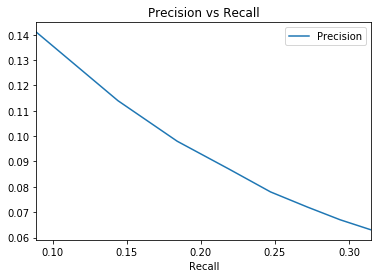

In [30]:
precision_recall(pred_splits_h, train_sets_h, test_sets_h, 2, is_binary = True)

### Evaluation

The mixture slightly improves on precision and recall, while managing about a 30% increase in coverage at a K of 30.  Getting 30% more titles in the recommender's mix will prevent boredom and keep users on our platform.  It should also start a virtuous cycle with more movies getting plays, and therefore, being familiar to the ALS side of the recommender. 

## Online Evaluation

For our online evaluation, we'll use measures typically seen in online marketing rather than statistics.  These will determine the business value of the recommender system.

**Click-through rate:** The number of clicks on the recommended items divided by the number of times it was shown <br>
**Conversion Rate:** The number of times the item was consumed as a result of the recommender divided by the number of times it was shown.

Conversion rate can be simulated to some degree with offline experiments.  This is essentially what we are doing when we do cross validation using recommendations against the test data.  However, there was no actual recommendation shown, and therefore, no cause and effect making the link dubious.

We could even go further towards the business side and measure the ROI of the recommender.  Labor costs would be somewhat difficult to determine but an estimate would be adequate for a directional number.

*To setup an online experiment:* At sign in time, each user could be taken to a different instance of the site with a different recommender depending on which group they assigned to. This group would be remembered across sessions. Since this is a movie streaming service, the user would be customer so we could uniquely identify them with ease.

Sources:
    
- https://grouplens.org/datasets/movielens/<br>
- “Practical Recommender Systems”, Kim Falk, January 2019<br>
- https://implicit.readthedocs.io/en/latest/quickstart.html<br>
-https://medium.com/recombee-blog/evaluating-recommender-systems-choosing-the-best-one-for-your-business-c688ab781a35<br>
- https://lkpy.readthedocs.io/en/stable/